In [63]:
# example of pix2pix gan for satellite to map image-to-image translation
import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model

In [64]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [65]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same',
    kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [66]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same',
    kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [67]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [68]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [69]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [70]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y


In [71]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [72]:
def create_trajectory(data_x, data_y, obs_len=10):
    K = np.array([[537.023764, 0, 640 , 0], 
                [0 , 537.023764, 180, 0], 
                    [0, 0, 1, 0]])
    Rt = np.array([[0.028841, 0.007189, 0.999558, 1.481009],
                        [-0.999575,  0.004514,  0.028809,  0.296583],
                        [ 0.004305,  0.999964, -0.007316, -1.544537],
                        [ 0.      ,  0.      ,  0.      ,  1.      ]])

    cv2_image = data_x.astype('uint8')
    cv2_image = cv2.resize(cv2_image, (1280,360))

    # Draw points
    for m in range(obs_len, data_y.shape[0]):
        A = np.matmul(np.linalg.inv(Rt), data_y[m, :].reshape(4, 1))
        B = np.matmul(K, A)

        x = int(B[0, 0] * 1.0 / B[2, 0])
        y = int(B[1, 0] * 1.0 / B[2, 0])
        if (x < 0 or x > 1280 - 1 or y > 360 - 1):
            continue
        cv2_image = cv2.circle(cv2_image, (x, y), 3, (0, 0, 255), -1)
    return cv2_image

In [73]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow((X_realA[i]* 255).astype(np.uint8))
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow((X_fakeB[i]* 255).astype(np.uint8))
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow((X_realB[i]* 255).astype(np.uint8))
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [82]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=50, n_batch=14):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)
            print('saved')

In [76]:
# load image data
dataset = load_real_samples('0000.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

Loaded (5866, 256, 256, 3) (5866, 256, 256, 3)


In [83]:
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

In [84]:
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

In [85]:
# train model
train(d_model, g_model, gan_model, dataset)

023] d2[0.018] g[6.115]
>20423, d1[0.013] d2[0.021] g[6.271]
>20424, d1[0.012] d2[0.019] g[6.212]
>20425, d1[0.006] d2[0.017] g[6.122]
>20426, d1[0.008] d2[0.018] g[6.211]
>20427, d1[0.005] d2[0.014] g[6.820]
>20428, d1[0.033] d2[0.020] g[6.038]
>20429, d1[0.005] d2[0.024] g[6.164]
>20430, d1[0.007] d2[0.014] g[6.533]
>20431, d1[0.005] d2[0.018] g[6.332]
>20432, d1[0.014] d2[0.013] g[6.548]
>20433, d1[0.002] d2[0.015] g[6.310]
>20434, d1[0.004] d2[0.015] g[6.296]
>20435, d1[0.007] d2[0.019] g[6.257]
>20436, d1[0.005] d2[0.018] g[5.987]
>20437, d1[0.006] d2[0.024] g[5.779]
>20438, d1[0.022] d2[0.013] g[6.565]
>20439, d1[0.004] d2[0.015] g[6.511]
>20440, d1[0.004] d2[0.025] g[6.198]
>20441, d1[0.007] d2[0.013] g[6.347]
>20442, d1[0.013] d2[0.031] g[7.061]
>20443, d1[0.026] d2[0.024] g[6.113]
>20444, d1[0.010] d2[0.017] g[6.565]
>20445, d1[0.002] d2[0.020] g[6.135]
>20446, d1[0.006] d2[0.028] g[6.275]
>20447, d1[0.009] d2[0.015] g[6.254]
>20448, d1[0.011] d2[0.023] g[6.270]
>20449, d1[0.0

# Translating Images

In [101]:
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
import cv2

In [ ]:
for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow((X_realA[i]* 255).astype(np.uint8))
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow((X_fakeB[i]* 255).astype(np.uint8))
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow((X_realB[i]* 255).astype(np.uint8))

In [146]:
# load and prepare training images
def load_real_samples(filename):
    # load the compressed arrays
    data = load(filename)
    # unpack the arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    return [X1, X2]
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img, filename):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = ((images + 1) * 255 / 2.0).astype(np.uint8)
    
    titles = ['Source', 'Generated', 'Expected']
    pyplot.figure(figsize=(32.0, 20.0))
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(3, 1, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        img = cv2.resize(images[i], (1280,360))
        pyplot.imshow(img)
        # show title
        pyplot.title(titles[i])
    pyplot.subplots_adjust(hspace=0.4)
    pyplot.savefig(filename)
    pyplot.show()
    
    

In [92]:
# load dataset
[X1, X2] = load_real_samples('0000.npz')
print('Loaded', X1.shape, X2.shape)

Loaded (5866, 256, 256, 3) (5866, 256, 256, 3)


In [195]:
# load model
model = load_model('model_020531.h5')

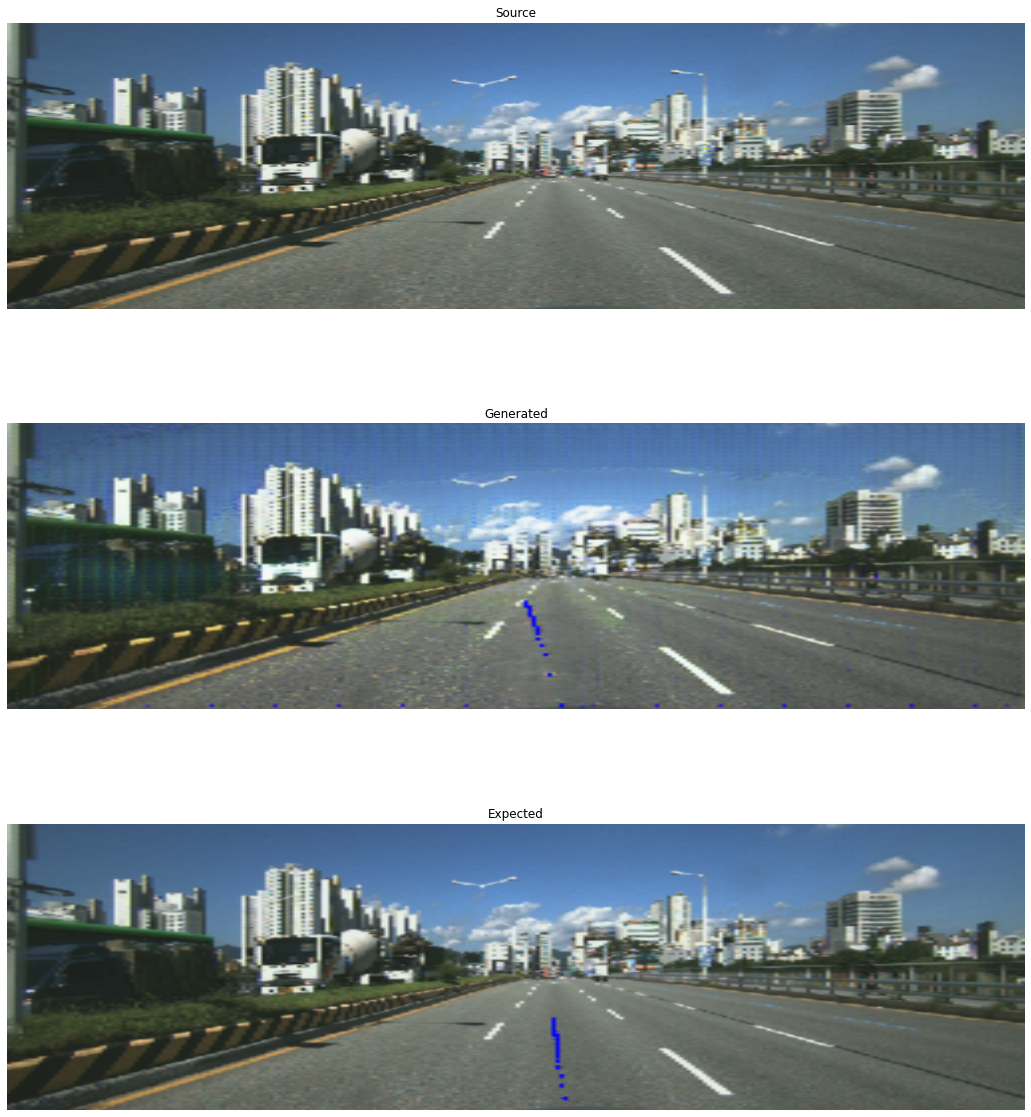

In [201]:
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
filename = 'sample12.png'
# plot all three images
plot_images(src_image, gen_image, tar_image, filename)